In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
d = pd.read_csv("../Python/Datasets/USD_INR.csv")['Price']
d = pd.concat([d, d.shift(-1), d.shift(-2), d.shift(-3), d.shift(-4), d.shift(-5)], axis=1).iloc[:-5]
d.columns = ['t-5', 't-4', 't-3', 't-2', 't-1', 'out']

split = int(0.7*d.shape[0])

In [3]:
input_train, output_train = d.values[:split,:-1].astype(np.float32), d.values[:split, -1].astype(np.float32)
input_test, output_test = d.values[split:,:-1].astype(np.float32), d.values[split:, -1].astype(np.float32)

In [4]:
rnn_units = 512
num_layers = 3
time_steps = 5
num_features = 1
batch_size=64

In [5]:
with tf.variable_scope("Inputs",reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype=tf.float32,shape=(None,time_steps),name='sequence')
    inputs = tf.split(x, time_steps, 1)
    y = tf.placeholder(dtype=tf.float32,shape=(None,),name='true')
    
with tf.variable_scope("Recurrent",reuse=tf.AUTO_REUSE):
    if num_layers == 1:
        rnn_cell = tf.contrib.rnn.LSTMCell(rnn_units,forget_bias=0.0,state_is_tuple=True,activation=tf.nn.relu)
    else:
        rnn_cell = tf.contrib.rnn.MultiRNNCell([
            tf.contrib.rnn.LSTMCell(rnn_units,forget_bias=0.0,state_is_tuple=True,activation=tf.nn.relu) 
            for _ in range(num_layers)], state_is_tuple=True)

with tf.variable_scope("Computations",reuse=tf.AUTO_REUSE):
    output, state = tf.contrib.rnn.static_rnn(cell=rnn_cell,inputs=inputs,dtype=tf.float32)
    
#     w1 = tf.get_variable("dense1_w",shape=(rnn_units,256),
#                          initializer=tf.random_uniform_initializer(dtype=tf.float32))
#     b1 = tf.get_variable("dense1_b",shape=(1,256),
#                          initializer=tf.random_uniform_initializer(dtype=tf.float32))

#     w2 = tf.get_variable("dense2_w",shape=(256,64),
#                          initializer=tf.random_uniform_initializer(dtype=tf.float32))
#     b2 = tf.get_variable("dense2_b",shape=(1,64),
#                          initializer=tf.random_uniform_initializer(dtype=tf.float32))

#     w3 = tf.get_variable("dense3_w",shape=(rnn_units,1),
#                          initializer=tf.random_uniform_initializer(dtype=tf.float32))
#     b3 = tf.get_variable("dense3_b",shape=(1,1),
#                          initializer=tf.random_uniform_initializer(dtype=tf.float32))

#     lval = tf.nn.relu(tf.add(tf.matmul(output[-1],w1),b1))
#     lval = tf.nn.relu(tf.add(tf.matmul(lval,w2),b2))
#     out = tf.add(tf.matmul(output[-1],w3),b3,name='Output')
    out = tf.reduce_mean(output[-1],axis=1,name='Output')

with tf.variable_scope("Training",reuse=tf.AUTO_REUSE):
    loss = tf.reduce_mean(tf.squared_difference(out,y),name='Loss')
    optim = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

with tf.variable_scope("Tensorboard", reuse=tf.AUTO_REUSE):
    tf.summary.histogram("Recurrent_Output",output[-1])
#     tf.summary.histogram("Weights_Dense1",w1)
#     tf.summary.histogram("Weights_Dense2",w2)
#     tf.summary.histogram("Weights_Dense3",w3)
    tf.summary.scalar("MSE_Loss",loss)

    merged_summary = tf.summary.merge_all()

In [6]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter("./logs/logs_rnn_1/run4/",sess.graph)
    sess.run(tf.global_variables_initializer())
    
    cnt=0
    for ep in range(50):
        print("Epoch : ", ep)
        for mini in range(0,input_train.shape[0],batch_size):
            summary, loss_val, _, output = sess.run([merged_summary, loss, optim, out],
                                                feed_dict={x:input_train[mini:mini+batch_size], 
                                                           y:output_train[mini:mini+batch_size]})
            print("Train \tBatch no : %d \tLoss : %0.5f" %(int(mini/batch_size), np.mean(loss_val)))
            writer.add_summary(summary,cnt)
            cnt+=1
        loss_val, outputs = sess.run([loss, out], feed_dict={x:input_test,y:output_test})
        print("Test \tBatch no : %d \tLoss : %0.5f" %(int(mini/batch_size), np.mean(loss_val)))
        print("------------------------------------------------------------------------------------")
    writer.close()
        

Epoch :  0
Train 	Batch no : 0 	Loss : 4147.87012
Train 	Batch no : 1 	Loss : 27862914.00000
Train 	Batch no : 2 	Loss : 4452.95557
Train 	Batch no : 3 	Loss : 4442.36670
Train 	Batch no : 4 	Loss : 4388.92676
Train 	Batch no : 5 	Loss : 3663.18188
Train 	Batch no : 6 	Loss : 897.43726
Train 	Batch no : 7 	Loss : 18071.53516
Train 	Batch no : 8 	Loss : 1149.28687
Train 	Batch no : 9 	Loss : 3419.61353
Train 	Batch no : 10 	Loss : 3806.32935
Train 	Batch no : 11 	Loss : 3730.01514
Train 	Batch no : 12 	Loss : 3610.75293
Train 	Batch no : 13 	Loss : 3633.54980
Train 	Batch no : 14 	Loss : 3844.88989
Train 	Batch no : 15 	Loss : 3911.08740
Train 	Batch no : 16 	Loss : 3620.62695
Train 	Batch no : 17 	Loss : 2873.15088
Train 	Batch no : 18 	Loss : 2480.02124
Train 	Batch no : 19 	Loss : 1311.40332
Train 	Batch no : 20 	Loss : 194.09061
Train 	Batch no : 21 	Loss : 61.54538
Train 	Batch no : 22 	Loss : 129.47075
Train 	Batch no : 23 	Loss : 110.90799
Train 	Batch no : 24 	Loss : 15.39776
Tr

Train 	Batch no : 2 	Loss : 104.33800
Train 	Batch no : 3 	Loss : 210.27444
Train 	Batch no : 4 	Loss : 129.83899
Train 	Batch no : 5 	Loss : 3.27952
Train 	Batch no : 6 	Loss : 108.23936
Train 	Batch no : 7 	Loss : 73.99197
Train 	Batch no : 8 	Loss : 0.51390
Train 	Batch no : 9 	Loss : 78.90437
Train 	Batch no : 10 	Loss : 92.63559
Train 	Batch no : 11 	Loss : 27.77782
Train 	Batch no : 12 	Loss : 10.22825
Train 	Batch no : 13 	Loss : 68.44003
Train 	Batch no : 14 	Loss : 68.89301
Train 	Batch no : 15 	Loss : 2.41086
Train 	Batch no : 16 	Loss : 19.28176
Train 	Batch no : 17 	Loss : 60.69878
Train 	Batch no : 18 	Loss : 56.51755
Train 	Batch no : 19 	Loss : 20.72670
Train 	Batch no : 20 	Loss : 1.01934
Train 	Batch no : 21 	Loss : 24.64718
Train 	Batch no : 22 	Loss : 25.14981
Train 	Batch no : 23 	Loss : 20.15001
Train 	Batch no : 24 	Loss : 0.43601
Train 	Batch no : 25 	Loss : 5.88294
Train 	Batch no : 26 	Loss : 13.54584
Train 	Batch no : 27 	Loss : 15.07383
Train 	Batch no : 28 	

Train 	Batch no : 5 	Loss : 24.26413
Train 	Batch no : 6 	Loss : 85.03034
Train 	Batch no : 7 	Loss : 5.02079
Train 	Batch no : 8 	Loss : 24.85340
Train 	Batch no : 9 	Loss : 55.23656
Train 	Batch no : 10 	Loss : 24.27068
Train 	Batch no : 11 	Loss : 1.20293
Train 	Batch no : 12 	Loss : 32.76577
Train 	Batch no : 13 	Loss : 24.37862
Train 	Batch no : 14 	Loss : 0.96034
Train 	Batch no : 15 	Loss : 16.49982
Train 	Batch no : 16 	Loss : 18.28454
Train 	Batch no : 17 	Loss : 9.51597
Train 	Batch no : 18 	Loss : 0.26724
Train 	Batch no : 19 	Loss : 10.78591
Train 	Batch no : 20 	Loss : 13.14509
Train 	Batch no : 21 	Loss : 2.34910
Train 	Batch no : 22 	Loss : 3.68923
Train 	Batch no : 23 	Loss : 6.34476
Train 	Batch no : 24 	Loss : 7.96858
Train 	Batch no : 25 	Loss : 3.82543
Train 	Batch no : 26 	Loss : 0.11349
Train 	Batch no : 27 	Loss : 2.42316
Train 	Batch no : 28 	Loss : 7.36340
Train 	Batch no : 29 	Loss : 5.41877
Train 	Batch no : 30 	Loss : 0.59862
Train 	Batch no : 31 	Loss : 0.7

Train 	Batch no : 7 	Loss : 8.98191
Train 	Batch no : 8 	Loss : 40.42088
Train 	Batch no : 9 	Loss : 18.52259
Train 	Batch no : 10 	Loss : 1.79465
Train 	Batch no : 11 	Loss : 28.75404
Train 	Batch no : 12 	Loss : 12.26279
Train 	Batch no : 13 	Loss : 2.52212
Train 	Batch no : 14 	Loss : 14.26815
Train 	Batch no : 15 	Loss : 6.60625
Train 	Batch no : 16 	Loss : 11.88734
Train 	Batch no : 17 	Loss : 1.81563
Train 	Batch no : 18 	Loss : 1.06350
Train 	Batch no : 19 	Loss : 3.94488
Train 	Batch no : 20 	Loss : 1.39633
Train 	Batch no : 21 	Loss : 1.11485
Train 	Batch no : 22 	Loss : 0.77116
Train 	Batch no : 23 	Loss : 2.02044
Train 	Batch no : 24 	Loss : 0.44210
Train 	Batch no : 25 	Loss : 1.48387
Train 	Batch no : 26 	Loss : 0.97430
Train 	Batch no : 27 	Loss : 0.22527
Train 	Batch no : 28 	Loss : 0.78782
Train 	Batch no : 29 	Loss : 1.54049
Train 	Batch no : 30 	Loss : 0.29113
Train 	Batch no : 31 	Loss : 0.26020
Train 	Batch no : 32 	Loss : 0.47012
Train 	Batch no : 33 	Loss : 0.9906

Train 	Batch no : 11 	Loss : 6.99287
Train 	Batch no : 12 	Loss : 3.49649
Train 	Batch no : 13 	Loss : 17.73760
Train 	Batch no : 14 	Loss : 4.91860
Train 	Batch no : 15 	Loss : 5.38732
Train 	Batch no : 16 	Loss : 15.04609
Train 	Batch no : 17 	Loss : 0.44649
Train 	Batch no : 18 	Loss : 4.31933
Train 	Batch no : 19 	Loss : 1.90389
Train 	Batch no : 20 	Loss : 3.76231
Train 	Batch no : 21 	Loss : 0.29338
Train 	Batch no : 22 	Loss : 3.04319
Train 	Batch no : 23 	Loss : 0.63466
Train 	Batch no : 24 	Loss : 0.34369
Train 	Batch no : 25 	Loss : 0.22788
Train 	Batch no : 26 	Loss : 0.32243
Train 	Batch no : 27 	Loss : 0.21647
Train 	Batch no : 28 	Loss : 0.19008
Train 	Batch no : 29 	Loss : 0.39992
Train 	Batch no : 30 	Loss : 0.36569
Train 	Batch no : 31 	Loss : 0.20809
Train 	Batch no : 32 	Loss : 0.40001
Train 	Batch no : 33 	Loss : 0.58625
Train 	Batch no : 34 	Loss : 0.56580
Train 	Batch no : 35 	Loss : 1.07094
Train 	Batch no : 36 	Loss : 0.70355
Train 	Batch no : 37 	Loss : 0.51532

Train 	Batch no : 14 	Loss : 1.67362
Train 	Batch no : 15 	Loss : 5.17709
Train 	Batch no : 16 	Loss : 3.68275
Train 	Batch no : 17 	Loss : 3.80798
Train 	Batch no : 18 	Loss : 8.26428
Train 	Batch no : 19 	Loss : 2.03409
Train 	Batch no : 20 	Loss : 2.86932
Train 	Batch no : 21 	Loss : 7.90761
Train 	Batch no : 22 	Loss : 0.48048
Train 	Batch no : 23 	Loss : 1.20274
Train 	Batch no : 24 	Loss : 3.43008
Train 	Batch no : 25 	Loss : 2.82531
Train 	Batch no : 26 	Loss : 0.23474
Train 	Batch no : 27 	Loss : 1.30189
Train 	Batch no : 28 	Loss : 3.09910
Train 	Batch no : 29 	Loss : 1.67743
Train 	Batch no : 30 	Loss : 0.30404
Train 	Batch no : 31 	Loss : 1.97087
Train 	Batch no : 32 	Loss : 1.75839
Train 	Batch no : 33 	Loss : 0.69553
Train 	Batch no : 34 	Loss : 1.41621
Train 	Batch no : 35 	Loss : 2.27801
Train 	Batch no : 36 	Loss : 0.90604
Train 	Batch no : 37 	Loss : 0.33637
Train 	Batch no : 38 	Loss : 1.48186
Train 	Batch no : 39 	Loss : 1.35878
Train 	Batch no : 40 	Loss : 0.37625
T

Train 	Batch no : 19 	Loss : 0.44235
Train 	Batch no : 20 	Loss : 1.76176
Train 	Batch no : 21 	Loss : 1.39950
Train 	Batch no : 22 	Loss : 1.21371
Train 	Batch no : 23 	Loss : 1.12308
Train 	Batch no : 24 	Loss : 0.48796
Train 	Batch no : 25 	Loss : 0.06718
Train 	Batch no : 26 	Loss : 0.34985
Train 	Batch no : 27 	Loss : 0.68604
Train 	Batch no : 28 	Loss : 0.23319
Train 	Batch no : 29 	Loss : 0.32509
Train 	Batch no : 30 	Loss : 0.67700
Train 	Batch no : 31 	Loss : 0.49036
Train 	Batch no : 32 	Loss : 0.19419
Train 	Batch no : 33 	Loss : 0.67343
Train 	Batch no : 34 	Loss : 0.96421
Train 	Batch no : 35 	Loss : 0.88988
Train 	Batch no : 36 	Loss : 0.41532
Train 	Batch no : 37 	Loss : 0.53433
Train 	Batch no : 38 	Loss : 0.45126
Train 	Batch no : 39 	Loss : 0.07086
Train 	Batch no : 40 	Loss : 0.18331
Train 	Batch no : 41 	Loss : 0.46383
Train 	Batch no : 42 	Loss : 0.23317
Train 	Batch no : 43 	Loss : 0.04808
Train 	Batch no : 44 	Loss : 0.18918
Train 	Batch no : 45 	Loss : 0.14229
T

Train 	Batch no : 22 	Loss : 2.94249
Train 	Batch no : 23 	Loss : 2.28495
Train 	Batch no : 24 	Loss : 0.22598
Train 	Batch no : 25 	Loss : 0.54062
Train 	Batch no : 26 	Loss : 1.07328
Train 	Batch no : 27 	Loss : 0.30415
Train 	Batch no : 28 	Loss : 0.57122
Train 	Batch no : 29 	Loss : 0.73988
Train 	Batch no : 30 	Loss : 0.36949
Train 	Batch no : 31 	Loss : 0.28352
Train 	Batch no : 32 	Loss : 0.82393
Train 	Batch no : 33 	Loss : 0.53642
Train 	Batch no : 34 	Loss : 0.44148
Train 	Batch no : 35 	Loss : 1.26398
Train 	Batch no : 36 	Loss : 0.36177
Train 	Batch no : 37 	Loss : 0.14693
Train 	Batch no : 38 	Loss : 0.04250
Train 	Batch no : 39 	Loss : 0.03646
Train 	Batch no : 40 	Loss : 0.07882
Train 	Batch no : 41 	Loss : 0.10119
Train 	Batch no : 42 	Loss : 0.08218
Train 	Batch no : 43 	Loss : 0.05994
Train 	Batch no : 44 	Loss : 0.02183
Train 	Batch no : 45 	Loss : 0.14597
Train 	Batch no : 46 	Loss : 0.03583
Train 	Batch no : 47 	Loss : 0.28155
Train 	Batch no : 48 	Loss : 0.03092
T

Train 	Batch no : 26 	Loss : 0.07714
Train 	Batch no : 27 	Loss : 0.26160
Train 	Batch no : 28 	Loss : 0.34497
Train 	Batch no : 29 	Loss : 0.33474
Train 	Batch no : 30 	Loss : 0.15016
Train 	Batch no : 31 	Loss : 0.23141
Train 	Batch no : 32 	Loss : 0.18102
Train 	Batch no : 33 	Loss : 0.53886
Train 	Batch no : 34 	Loss : 0.42430
Train 	Batch no : 35 	Loss : 0.87875
Train 	Batch no : 36 	Loss : 0.55802
Train 	Batch no : 37 	Loss : 0.14523
Train 	Batch no : 38 	Loss : 0.25707
Train 	Batch no : 39 	Loss : 0.19924
Train 	Batch no : 40 	Loss : 0.08604
Train 	Batch no : 41 	Loss : 0.19360
Train 	Batch no : 42 	Loss : 0.19290
Train 	Batch no : 43 	Loss : 0.09730
Train 	Batch no : 44 	Loss : 0.06557
Train 	Batch no : 45 	Loss : 0.09873
Train 	Batch no : 46 	Loss : 0.05139
Train 	Batch no : 47 	Loss : 0.14501
Train 	Batch no : 48 	Loss : 0.13954
Train 	Batch no : 49 	Loss : 0.03312
Train 	Batch no : 50 	Loss : 0.01747
Train 	Batch no : 51 	Loss : 0.20558
Train 	Batch no : 52 	Loss : 0.04336
T

Train 	Batch no : 31 	Loss : 0.28935
Train 	Batch no : 32 	Loss : 0.22324
Train 	Batch no : 33 	Loss : 0.53947
Train 	Batch no : 34 	Loss : 0.42707
Train 	Batch no : 35 	Loss : 0.87648
Train 	Batch no : 36 	Loss : 0.59743
Train 	Batch no : 37 	Loss : 0.14187
Train 	Batch no : 38 	Loss : 0.23841
Train 	Batch no : 39 	Loss : 0.19232
Train 	Batch no : 40 	Loss : 0.08269
Train 	Batch no : 41 	Loss : 0.20513
Train 	Batch no : 42 	Loss : 0.17555
Train 	Batch no : 43 	Loss : 0.07037
Train 	Batch no : 44 	Loss : 0.09430
Train 	Batch no : 45 	Loss : 0.09089
Train 	Batch no : 46 	Loss : 0.03177
Train 	Batch no : 47 	Loss : 0.13011
Train 	Batch no : 48 	Loss : 0.12602
Train 	Batch no : 49 	Loss : 0.01185
Train 	Batch no : 50 	Loss : 0.03173
Train 	Batch no : 51 	Loss : 0.19287
Train 	Batch no : 52 	Loss : 0.02010
Train 	Batch no : 53 	Loss : 0.26260
Train 	Batch no : 54 	Loss : 0.15146
Train 	Batch no : 55 	Loss : 0.07093
Train 	Batch no : 56 	Loss : 0.12110
Train 	Batch no : 57 	Loss : 0.01764
T

Train 	Batch no : 35 	Loss : 1.41040
Train 	Batch no : 36 	Loss : 0.38619
Train 	Batch no : 37 	Loss : 0.89750
Train 	Batch no : 38 	Loss : 0.90407
Train 	Batch no : 39 	Loss : 0.05048
Train 	Batch no : 40 	Loss : 0.55507
Train 	Batch no : 41 	Loss : 0.73832
Train 	Batch no : 42 	Loss : 0.07752
Train 	Batch no : 43 	Loss : 0.36300
Train 	Batch no : 44 	Loss : 0.38314
Train 	Batch no : 45 	Loss : 0.22064
Train 	Batch no : 46 	Loss : 0.31111
Train 	Batch no : 47 	Loss : 0.12279
Train 	Batch no : 48 	Loss : 0.05742
Train 	Batch no : 49 	Loss : 0.17264
Train 	Batch no : 50 	Loss : 0.02315
Train 	Batch no : 51 	Loss : 0.12732
Train 	Batch no : 52 	Loss : 0.14938
Train 	Batch no : 53 	Loss : 0.13067
Train 	Batch no : 54 	Loss : 0.29530
Train 	Batch no : 55 	Loss : 0.21955
Train 	Batch no : 56 	Loss : 0.02086
Train 	Batch no : 57 	Loss : 0.16549
Train 	Batch no : 58 	Loss : 0.11610
Train 	Batch no : 59 	Loss : 0.03194
Train 	Batch no : 60 	Loss : 0.17033
Train 	Batch no : 61 	Loss : 0.01410
T

Train 	Batch no : 38 	Loss : 0.04889
Train 	Batch no : 39 	Loss : 0.34156
Train 	Batch no : 40 	Loss : 0.40897
Train 	Batch no : 41 	Loss : 0.10027
Train 	Batch no : 42 	Loss : 0.40399
Train 	Batch no : 43 	Loss : 0.13593
Train 	Batch no : 44 	Loss : 0.06412
Train 	Batch no : 45 	Loss : 0.53570
Train 	Batch no : 46 	Loss : 0.03422
Train 	Batch no : 47 	Loss : 0.63707
Train 	Batch no : 48 	Loss : 0.04070
Train 	Batch no : 49 	Loss : 0.08515
Train 	Batch no : 50 	Loss : 0.17618
Train 	Batch no : 51 	Loss : 0.11109
Train 	Batch no : 52 	Loss : 0.10695
Train 	Batch no : 53 	Loss : 0.07019
Train 	Batch no : 54 	Loss : 0.14068
Train 	Batch no : 55 	Loss : 0.02548
Train 	Batch no : 56 	Loss : 0.02159
Train 	Batch no : 57 	Loss : 0.02066
Train 	Batch no : 58 	Loss : 0.00560
Train 	Batch no : 59 	Loss : 0.01613
Train 	Batch no : 60 	Loss : 0.00125
Train 	Batch no : 61 	Loss : 0.01215
Train 	Batch no : 62 	Loss : 0.00164
Train 	Batch no : 63 	Loss : 0.02095
Train 	Batch no : 64 	Loss : 0.02345
T

Train 	Batch no : 41 	Loss : 0.10067
Train 	Batch no : 42 	Loss : 0.10251
Train 	Batch no : 43 	Loss : 0.11583
Train 	Batch no : 44 	Loss : 0.03616
Train 	Batch no : 45 	Loss : 0.08420
Train 	Batch no : 46 	Loss : 0.04119
Train 	Batch no : 47 	Loss : 0.15018
Train 	Batch no : 48 	Loss : 0.15771
Train 	Batch no : 49 	Loss : 0.01163
Train 	Batch no : 50 	Loss : 0.05173
Train 	Batch no : 51 	Loss : 0.19134
Train 	Batch no : 52 	Loss : 0.03444
Train 	Batch no : 53 	Loss : 0.34267
Train 	Batch no : 54 	Loss : 0.15375
Train 	Batch no : 55 	Loss : 0.24280
Train 	Batch no : 56 	Loss : 0.03977
Train 	Batch no : 57 	Loss : 0.12887
Train 	Batch no : 58 	Loss : 0.11041
Train 	Batch no : 59 	Loss : 0.04860
Train 	Batch no : 60 	Loss : 0.13882
Train 	Batch no : 61 	Loss : 0.00519
Train 	Batch no : 62 	Loss : 0.18013
Train 	Batch no : 63 	Loss : 0.01524
Train 	Batch no : 64 	Loss : 0.16195
Train 	Batch no : 65 	Loss : 0.04541
Train 	Batch no : 66 	Loss : 0.10478
Train 	Batch no : 67 	Loss : 0.06049
T

Train 	Batch no : 45 	Loss : 0.08615
Train 	Batch no : 46 	Loss : 1.98871
Train 	Batch no : 47 	Loss : 0.46887
Train 	Batch no : 48 	Loss : 2.19892
Train 	Batch no : 49 	Loss : 0.34136
Train 	Batch no : 50 	Loss : 1.00213
Train 	Batch no : 51 	Loss : 1.22400
Train 	Batch no : 52 	Loss : 0.45184
Train 	Batch no : 53 	Loss : 1.74809
Train 	Batch no : 54 	Loss : 0.51646
Train 	Batch no : 55 	Loss : 1.62851
Train 	Batch no : 56 	Loss : 0.03980
Train 	Batch no : 57 	Loss : 1.45718
Train 	Batch no : 58 	Loss : 0.00849
Train 	Batch no : 59 	Loss : 1.17427
Train 	Batch no : 60 	Loss : 0.04707
Train 	Batch no : 61 	Loss : 0.96533
Train 	Batch no : 62 	Loss : 0.05055
Train 	Batch no : 63 	Loss : 0.74562
Train 	Batch no : 64 	Loss : 0.11615
Train 	Batch no : 65 	Loss : 0.46113
Train 	Batch no : 66 	Loss : 0.17199
Train 	Batch no : 67 	Loss : 0.36734
Train 	Batch no : 68 	Loss : 0.15069
Train 	Batch no : 69 	Loss : 0.18742
Train 	Batch no : 70 	Loss : 0.17431
Train 	Batch no : 71 	Loss : 0.08019
T

Train 	Batch no : 45 	Loss : 3.68576
Train 	Batch no : 46 	Loss : 13.71461
Train 	Batch no : 47 	Loss : 12.40343
Train 	Batch no : 48 	Loss : 6.97783
Train 	Batch no : 49 	Loss : 0.43398
Train 	Batch no : 50 	Loss : 1.70731
Train 	Batch no : 51 	Loss : 8.19762
Train 	Batch no : 52 	Loss : 13.84656
Train 	Batch no : 53 	Loss : 7.21113
Train 	Batch no : 54 	Loss : 0.98740
Train 	Batch no : 55 	Loss : 0.39940
Train 	Batch no : 56 	Loss : 3.94449
Train 	Batch no : 57 	Loss : 5.49293
Train 	Batch no : 58 	Loss : 3.12717
Train 	Batch no : 59 	Loss : 0.38947
Train 	Batch no : 60 	Loss : 0.41078
Train 	Batch no : 61 	Loss : 2.42835
Train 	Batch no : 62 	Loss : 2.77314
Train 	Batch no : 63 	Loss : 0.99760
Train 	Batch no : 64 	Loss : 0.03534
Train 	Batch no : 65 	Loss : 0.67583
Train 	Batch no : 66 	Loss : 1.66166
Train 	Batch no : 67 	Loss : 1.28060
Train 	Batch no : 68 	Loss : 0.56280
Train 	Batch no : 69 	Loss : 0.11534
Train 	Batch no : 70 	Loss : 0.02640
Train 	Batch no : 71 	Loss : 0.5347

Train 	Batch no : 47 	Loss : 4.73615
Train 	Batch no : 48 	Loss : 6.65537
Train 	Batch no : 49 	Loss : 3.16661
Train 	Batch no : 50 	Loss : 0.27702
Train 	Batch no : 51 	Loss : 1.02125
Train 	Batch no : 52 	Loss : 5.06952
Train 	Batch no : 53 	Loss : 4.56856
Train 	Batch no : 54 	Loss : 2.18639
Train 	Batch no : 55 	Loss : 0.59902
Train 	Batch no : 56 	Loss : 0.07305
Train 	Batch no : 57 	Loss : 0.82905
Train 	Batch no : 58 	Loss : 1.52505
Train 	Batch no : 59 	Loss : 1.38960
Train 	Batch no : 60 	Loss : 0.49891
Train 	Batch no : 61 	Loss : 0.00183
Train 	Batch no : 62 	Loss : 0.26411
Train 	Batch no : 63 	Loss : 0.42852
Train 	Batch no : 64 	Loss : 0.37140
Train 	Batch no : 65 	Loss : 0.08930
Train 	Batch no : 66 	Loss : 0.01249
Train 	Batch no : 67 	Loss : 0.05837
Train 	Batch no : 68 	Loss : 0.26520
Train 	Batch no : 69 	Loss : 0.53616
Train 	Batch no : 70 	Loss : 0.53671
Train 	Batch no : 71 	Loss : 0.07179
Train 	Batch no : 72 	Loss : 0.04808
Train 	Batch no : 73 	Loss : 0.28499
T

Train 	Batch no : 49 	Loss : 2.35968
Train 	Batch no : 50 	Loss : 0.20481
Train 	Batch no : 51 	Loss : 0.84530
Train 	Batch no : 52 	Loss : 4.05113
Train 	Batch no : 53 	Loss : 3.49593
Train 	Batch no : 54 	Loss : 1.63872
Train 	Batch no : 55 	Loss : 0.44257
Train 	Batch no : 56 	Loss : 0.06209
Train 	Batch no : 57 	Loss : 0.60005
Train 	Batch no : 58 	Loss : 1.09119
Train 	Batch no : 59 	Loss : 1.02557
Train 	Batch no : 60 	Loss : 0.39583
Train 	Batch no : 61 	Loss : 0.00267
Train 	Batch no : 62 	Loss : 0.15550
Train 	Batch no : 63 	Loss : 0.26261
Train 	Batch no : 64 	Loss : 0.24758
Train 	Batch no : 65 	Loss : 0.06331
Train 	Batch no : 66 	Loss : 0.01153
Train 	Batch no : 67 	Loss : 0.02711
Train 	Batch no : 68 	Loss : 0.17206
Train 	Batch no : 69 	Loss : 0.40268
Train 	Batch no : 70 	Loss : 0.45171
Train 	Batch no : 71 	Loss : 0.07257
Train 	Batch no : 72 	Loss : 0.02661
Train 	Batch no : 73 	Loss : 0.19691
Train 	Batch no : 74 	Loss : 0.21171
Train 	Batch no : 75 	Loss : 0.23618
T

Train 	Batch no : 53 	Loss : 3.23794
Train 	Batch no : 54 	Loss : 1.39052
Train 	Batch no : 55 	Loss : 0.28606
Train 	Batch no : 56 	Loss : 0.12092
Train 	Batch no : 57 	Loss : 0.69947
Train 	Batch no : 58 	Loss : 1.07476
Train 	Batch no : 59 	Loss : 0.87433
Train 	Batch no : 60 	Loss : 0.26289
Train 	Batch no : 61 	Loss : 0.00815
Train 	Batch no : 62 	Loss : 0.21315
Train 	Batch no : 63 	Loss : 0.27208
Train 	Batch no : 64 	Loss : 0.20510
Train 	Batch no : 65 	Loss : 0.02989
Train 	Batch no : 66 	Loss : 0.01957
Train 	Batch no : 67 	Loss : 0.04955
Train 	Batch no : 68 	Loss : 0.18910
Train 	Batch no : 69 	Loss : 0.36355
Train 	Batch no : 70 	Loss : 0.35923
Train 	Batch no : 71 	Loss : 0.03532
Train 	Batch no : 72 	Loss : 0.05136
Train 	Batch no : 73 	Loss : 0.22613
Train 	Batch no : 74 	Loss : 0.21029
Train 	Batch no : 75 	Loss : 0.20251
Train 	Batch no : 76 	Loss : 0.09258
Train 	Batch no : 77 	Loss : 0.08810
Train 	Batch no : 78 	Loss : 0.58725
Train 	Batch no : 79 	Loss : 0.78888
T

Train 	Batch no : 55 	Loss : 0.28270
Train 	Batch no : 56 	Loss : 0.08624
Train 	Batch no : 57 	Loss : 0.55332
Train 	Batch no : 58 	Loss : 0.90011
Train 	Batch no : 59 	Loss : 0.78406
Train 	Batch no : 60 	Loss : 0.26933
Train 	Batch no : 61 	Loss : 0.00222
Train 	Batch no : 62 	Loss : 0.14647
Train 	Batch no : 63 	Loss : 0.20985
Train 	Batch no : 64 	Loss : 0.18024
Train 	Batch no : 65 	Loss : 0.03526
Train 	Batch no : 66 	Loss : 0.01317
Train 	Batch no : 67 	Loss : 0.02787
Train 	Batch no : 68 	Loss : 0.14949
Train 	Batch no : 69 	Loss : 0.32362
Train 	Batch no : 70 	Loss : 0.34865
Train 	Batch no : 71 	Loss : 0.04531
Train 	Batch no : 72 	Loss : 0.03174
Train 	Batch no : 73 	Loss : 0.17558
Train 	Batch no : 74 	Loss : 0.17527
Train 	Batch no : 75 	Loss : 0.18648
Train 	Batch no : 76 	Loss : 0.09672
Train 	Batch no : 77 	Loss : 0.09608
Train 	Batch no : 78 	Loss : 0.50020
Train 	Batch no : 79 	Loss : 0.68580
Train 	Batch no : 80 	Loss : 1.44585
Train 	Batch no : 81 	Loss : 0.71540
T

Train 	Batch no : 59 	Loss : 0.61038
Train 	Batch no : 60 	Loss : 0.13418
Train 	Batch no : 61 	Loss : 0.02953
Train 	Batch no : 62 	Loss : 0.22015
Train 	Batch no : 63 	Loss : 0.21966
Train 	Batch no : 64 	Loss : 0.13392
Train 	Batch no : 65 	Loss : 0.00757
Train 	Batch no : 66 	Loss : 0.03543
Train 	Batch no : 67 	Loss : 0.05915
Train 	Batch no : 68 	Loss : 0.16865
Train 	Batch no : 69 	Loss : 0.27217
Train 	Batch no : 70 	Loss : 0.23666
Train 	Batch no : 71 	Loss : 0.00999
Train 	Batch no : 72 	Loss : 0.07060
Train 	Batch no : 73 	Loss : 0.21044
Train 	Batch no : 74 	Loss : 0.16933
Train 	Batch no : 75 	Loss : 0.14141
Train 	Batch no : 76 	Loss : 0.04988
Train 	Batch no : 77 	Loss : 0.07414
Train 	Batch no : 78 	Loss : 0.54981
Train 	Batch no : 79 	Loss : 0.66268
Train 	Batch no : 80 	Loss : 1.24309
Train 	Batch no : 81 	Loss : 0.51632
Train 	Batch no : 82 	Loss : 0.03324
Train 	Batch no : 83 	Loss : 0.10556
Train 	Batch no : 84 	Loss : 0.43456
Train 	Batch no : 85 	Loss : 0.64952
T

Train 	Batch no : 61 	Loss : 0.80348
Train 	Batch no : 62 	Loss : 0.37354
Train 	Batch no : 63 	Loss : 0.01283
Train 	Batch no : 64 	Loss : 0.27310
Train 	Batch no : 65 	Loss : 0.59096
Train 	Batch no : 66 	Loss : 0.52470
Train 	Batch no : 67 	Loss : 0.11314
Train 	Batch no : 68 	Loss : 0.03289
Train 	Batch no : 69 	Loss : 0.04403
Train 	Batch no : 70 	Loss : 0.05071
Train 	Batch no : 71 	Loss : 0.17299
Train 	Batch no : 72 	Loss : 0.22337
Train 	Batch no : 73 	Loss : 0.11158
Train 	Batch no : 74 	Loss : 0.01138
Train 	Batch no : 75 	Loss : 0.02653
Train 	Batch no : 76 	Loss : 0.08379
Train 	Batch no : 77 	Loss : 0.14501
Train 	Batch no : 78 	Loss : 0.64350
Train 	Batch no : 79 	Loss : 0.43114
Train 	Batch no : 80 	Loss : 0.60388
Train 	Batch no : 81 	Loss : 0.09456
Train 	Batch no : 82 	Loss : 0.05527
Train 	Batch no : 83 	Loss : 0.39390
Train 	Batch no : 84 	Loss : 0.63724
Train 	Batch no : 85 	Loss : 0.58319
Train 	Batch no : 86 	Loss : 0.21238
Train 	Batch no : 87 	Loss : 0.67370
T

Train 	Batch no : 65 	Loss : 0.16519
Train 	Batch no : 66 	Loss : 0.32719
Train 	Batch no : 67 	Loss : 0.18287
Train 	Batch no : 68 	Loss : 0.11776
Train 	Batch no : 69 	Loss : 0.06094
Train 	Batch no : 70 	Loss : 0.01544
Train 	Batch no : 71 	Loss : 0.08074
Train 	Batch no : 72 	Loss : 0.24309
Train 	Batch no : 73 	Loss : 0.23356
Train 	Batch no : 74 	Loss : 0.06641
Train 	Batch no : 75 	Loss : 0.00837
Train 	Batch no : 76 	Loss : 0.01878
Train 	Batch no : 77 	Loss : 0.12383
Train 	Batch no : 78 	Loss : 0.70835
Train 	Batch no : 79 	Loss : 0.56351
Train 	Batch no : 80 	Loss : 0.79149
Train 	Batch no : 81 	Loss : 0.16464
Train 	Batch no : 82 	Loss : 0.02236
Train 	Batch no : 83 	Loss : 0.32937
Train 	Batch no : 84 	Loss : 0.62085
Train 	Batch no : 85 	Loss : 0.62752
Train 	Batch no : 86 	Loss : 0.27681
Train 	Batch no : 87 	Loss : 0.74333
Train 	Batch no : 88 	Loss : 0.15715
Train 	Batch no : 89 	Loss : 0.71760
Train 	Batch no : 90 	Loss : 0.64301
Train 	Batch no : 91 	Loss : 0.53060
T

Train 	Batch no : 67 	Loss : 0.19991
Train 	Batch no : 68 	Loss : 0.08844
Train 	Batch no : 69 	Loss : 0.03190
Train 	Batch no : 70 	Loss : 0.01423
Train 	Batch no : 71 	Loss : 0.13490
Train 	Batch no : 72 	Loss : 0.27501
Train 	Batch no : 73 	Loss : 0.20837
Train 	Batch no : 74 	Loss : 0.03749
Train 	Batch no : 75 	Loss : 0.00290
Train 	Batch no : 76 	Loss : 0.04725
Train 	Batch no : 77 	Loss : 0.15004
Train 	Batch no : 78 	Loss : 0.70723
Train 	Batch no : 79 	Loss : 0.50630
Train 	Batch no : 80 	Loss : 0.67272
Train 	Batch no : 81 	Loss : 0.10929
Train 	Batch no : 82 	Loss : 0.04791
Train 	Batch no : 83 	Loss : 0.38306
Train 	Batch no : 84 	Loss : 0.63889
Train 	Batch no : 85 	Loss : 0.59332
Train 	Batch no : 86 	Loss : 0.23146
Train 	Batch no : 87 	Loss : 0.67257
Train 	Batch no : 88 	Loss : 0.16484
Train 	Batch no : 89 	Loss : 0.79499
Train 	Batch no : 90 	Loss : 0.68240
Train 	Batch no : 91 	Loss : 0.52912
Train 	Batch no : 92 	Loss : 0.24080
Train 	Batch no : 93 	Loss : 0.03660
T

Train 	Batch no : 71 	Loss : 0.10289
Train 	Batch no : 72 	Loss : 0.04263
Train 	Batch no : 73 	Loss : 0.00799
Train 	Batch no : 74 	Loss : 0.10046
Train 	Batch no : 75 	Loss : 0.10628
Train 	Batch no : 76 	Loss : 0.07877
Train 	Batch no : 77 	Loss : 0.08214
Train 	Batch no : 78 	Loss : 0.29214
Train 	Batch no : 79 	Loss : 0.20644
Train 	Batch no : 80 	Loss : 0.31128
Train 	Batch no : 81 	Loss : 0.03543
Train 	Batch no : 82 	Loss : 0.06804
Train 	Batch no : 83 	Loss : 0.28009
Train 	Batch no : 84 	Loss : 0.36768
Train 	Batch no : 85 	Loss : 0.27973
Train 	Batch no : 86 	Loss : 0.07316
Train 	Batch no : 87 	Loss : 0.50591
Train 	Batch no : 88 	Loss : 0.20029
Train 	Batch no : 89 	Loss : 0.83137
Train 	Batch no : 90 	Loss : 0.56319
Train 	Batch no : 91 	Loss : 0.33043
Train 	Batch no : 92 	Loss : 0.08542
Train 	Batch no : 93 	Loss : 0.00011
Train 	Batch no : 94 	Loss : 0.07764
Train 	Batch no : 95 	Loss : 0.21941
Train 	Batch no : 96 	Loss : 0.30291
Train 	Batch no : 97 	Loss : 0.27195
T

Train 	Batch no : 73 	Loss : 0.19020
Train 	Batch no : 74 	Loss : 0.43623
Train 	Batch no : 75 	Loss : 0.34453
Train 	Batch no : 76 	Loss : 0.07391
Train 	Batch no : 77 	Loss : 0.10174
Train 	Batch no : 78 	Loss : 0.06985
Train 	Batch no : 79 	Loss : 0.17539
Train 	Batch no : 80 	Loss : 0.15520
Train 	Batch no : 81 	Loss : 0.02287
Train 	Batch no : 82 	Loss : 0.04476
Train 	Batch no : 83 	Loss : 0.11105
Train 	Batch no : 84 	Loss : 0.09009
Train 	Batch no : 85 	Loss : 0.05412
Train 	Batch no : 86 	Loss : 0.04745
Train 	Batch no : 87 	Loss : 0.42777
Train 	Batch no : 88 	Loss : 0.22154
Train 	Batch no : 89 	Loss : 0.67741
Train 	Batch no : 90 	Loss : 0.31118
Train 	Batch no : 91 	Loss : 0.11691
Train 	Batch no : 92 	Loss : 0.00302
Train 	Batch no : 93 	Loss : 0.04113
Train 	Batch no : 94 	Loss : 0.15366
Train 	Batch no : 95 	Loss : 0.23827
Train 	Batch no : 96 	Loss : 0.23075
Train 	Batch no : 97 	Loss : 0.14541
Train 	Batch no : 98 	Loss : 0.04929
Train 	Batch no : 99 	Loss : 0.22221
T

In [7]:
pred = np.reshape(outputs,(-1,1))
true = np.reshape(output_test,(-1,1))

In [8]:
np.mean(np.abs(pred-true))

0.9384053

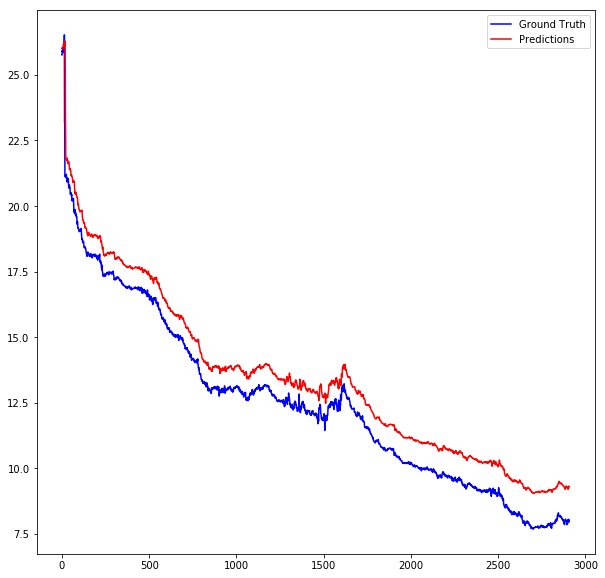

In [9]:
plt.figure(figsize=(10,10))
plt.plot(true,'b',label='Ground Truth')
plt.plot(pred,'r',label='Predictions')
plt.legend()
plt.show()